Total unique data points: 280653
Offset range: -509 to 509
Fragment size range: 40 to 500


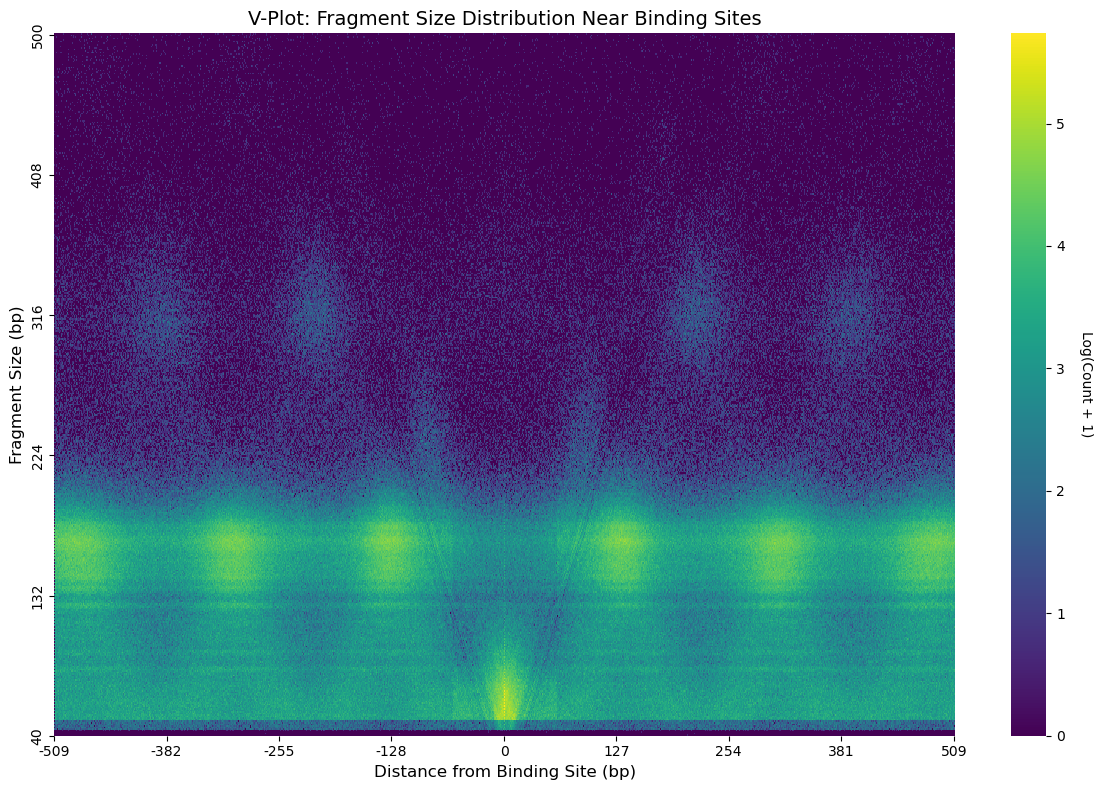

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gzip

def generate_vplot_matrix(input_file, distance_cutoff=1000, max_size=500):
    vplot_counts = defaultdict(int)

    with gzip.open(input_file, 'rt') as file:
        for idx, line in enumerate(file, 1):
            try:
                fields = line.strip().split('\t')

                binding_center = (int(fields[2]) + int(fields[3])) / 2
                fragment_center = (int(fields[8]) + int(fields[9])) / 2

                offset = int(fragment_center - binding_center)
                frag_length = int(fields[9]) - int(fields[8])

                if abs(offset) <= distance_cutoff and frag_length <= max_size:
                    vplot_counts[(offset, frag_length)] += 1

            except (IndexError, ValueError) as err:
                print(f"Skipping line {idx} due to error: {err}")
                continue

    x_vals = sorted({pos for pos, _ in vplot_counts})
    y_vals = sorted({size for _, size in vplot_counts})

    print(f"Total unique data points: {len(vplot_counts)}")
    print(f"Offset range: {min(x_vals)} to {max(x_vals)}")
    print(f"Fragment size range: {min(y_vals)} to {max(y_vals)}")

    heatmap_matrix = np.zeros((len(y_vals), len(x_vals)))

    for i, size in enumerate(y_vals):
        for j, offset in enumerate(x_vals):
            heatmap_matrix[i, j] = vplot_counts.get((offset, size), 0)

    return x_vals, y_vals, heatmap_matrix

# Visualization
try:
    file_path = "mapped.bed.gz"
    x_positions, y_lengths, density = generate_vplot_matrix(file_path)

    plt.figure(figsize=(12, 8))
    log_density = np.log1p(density)

    heatmap = sns.heatmap(log_density, cmap='viridis',
                          xticklabels=500, yticklabels=50)

    # Custom ticks
    xtick_pos = np.linspace(0, len(x_positions)-1, 9).astype(int)
    plt.xticks(xtick_pos, [x_positions[i] for i in xtick_pos])

    ytick_pos = np.linspace(0, len(y_lengths)-1, 6).astype(int)
    plt.yticks(ytick_pos, [y_lengths[i] for i in ytick_pos])

    # Labels
    plt.xlabel('Distance from Binding Site (bp)', fontsize=12)
    plt.ylabel('Fragment Size (bp)', fontsize=12)
    plt.title('V-Plot: Fragment Size Distribution Near Binding Sites', fontsize=14)

    # Adjust axis
    plt.gca().invert_yaxis()

    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Log(Count + 1)', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Input file '{file_path}' not found.")
except Exception as e:
    print(f"Unexpected error during visualization: {str(e)}")
